<h1 align = center> <font size = 5, color = blue> Coursera assignment: Segmenting and Clustering Neighborhoods in Toronto </h1>

## Part One
Data scraping and cleaning from Wikipedia.

First, import all necessary libraries.

In [2]:
#!conda install lxml --yes

In [3]:
import requests # library to handle requests
import lxml.html as lh # library to parse the relevant fields
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Libraries imported.')

Libraries imported.


To scrape data from Wikipedia page https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, I first download the HTML file and save it in local directory.

In [4]:
# read HTML file from local directory
with open(r'List-of-postal-codes-of-Canada.html', "r", encoding='UTF-8') as f:
    page = f.read()
    
# store the contents of the HTML file under doc
doc = lh.fromstring(page)

# parse data that are stored between <tr> .. </tr> of HTML
tr_elements = doc.xpath('//tr')

# parse table header
col = []
i = 0

for t in tr_elements[0]:
    i += 1
    name = t.text_content()
    print('%d: %s'%(i,name))
    col.append((name, []))

1: Postcode
2: Borough
3: Neighbourhood



Import raw data from HTML table to panda dataframe.

In [5]:
for j in range(1, len(tr_elements)):
    T = tr_elements[j]
    
    # check if the data is of size 3
    if (len(T) != 3):
        break
    
    i = 0
    
    for t in T:
        data = t.text_content()
        # append the data to the empty list of the i'th column
        col[i][1].append(data)
        i += 1
        
dic = {title:column for (title,column) in col}
df = pd.DataFrame(dic)

df = df[['Postcode', 'Borough', 'Neighbourhood\n']]      # reorganize dataframe
df.columns = ['PostalCode', 'Borough', 'Neighborhood']  # rename columns
df['Neighborhood'] = list(map(lambda i: i[ : -1], df['Neighborhood'] ))
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


First step of data cleaning: ignore cells with a borough that is not assigned and replace neighborhood name with borough name if a cell has a borough but a Not Assigned neighborhood.

In [6]:
# ignore cells with a borough that is not assigned
df['Borough'].replace('Not assigned',np.nan,inplace=True)
df.dropna(axis=0, inplace=True)

# replace neighborhood name with borough name if a cell has a borough but a Not Assigned neighborhood
for i in df[df['Neighborhood'] == 'Not assigned'].index:
    df.loc[i,'Neighborhood'] = df.loc[i,'Borough']

df.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


Combines rows with the same postal code and separate neighborhoods with commas.

In [7]:
column_names = ['PostalCode', 'Borough', 'Neighborhood']

df_comb = pd.DataFrame(columns = column_names)

ind = df.groupby('PostalCode').indices

for postalcode in ind.keys():
    borough = df.iloc[ind[postalcode][0],1]

    neighborhood = ', '.join(df.iloc[ind[postalcode],2].values)
    
    df_comb = df_comb.append({
        'PostalCode': postalcode,
        'Borough': borough,
        'Neighborhood':neighborhood
    }, ignore_index=True)
    
df_comb

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv..."
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."


As required by the assignment, print the number of rows using .shape method.

In [8]:
df_comb.shape

(103, 3)

## Part Two
Import geospatial coordinates from csv file and add to the dataframe created above.

In [9]:
# import coordinates recorded in Geospatial_Coordinates.csv
coordinates = pd.read_csv('Geospatial_Coordinates.csv')

# add Latitude and Longitude columns in df_comb
df_comb['Latitude'] = coordinates['Latitude']
df_comb['Longitude'] = coordinates['Longitude']

df_comb

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437


## Part Three
Explore and cluster the neighborhoods in Toronto.

In [10]:
# Select boroughs that contain the word Toronto
central = df_comb[df_comb['Borough'] == 'Central Toronto']
downtown = df_comb[df_comb['Borough'] == 'Downtown Toronto']
east = df_comb[df_comb['Borough'] == 'East Toronto']
west = df_comb[df_comb['Borough'] == 'West Toronto']

toronto = pd.concat([central, downtown, east, west]).reset_index(drop=True)
toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
5,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049
6,M5N,Central Toronto,Roselawn,43.711695,-79.416936
7,M5P,Central Toronto,"Forest Hill North, Forest Hill West",43.696948,-79.411307
8,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678
9,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529


Visualize neighborhoods in Toronto.

In [11]:
# get the geographical coordinates of Toronto
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
#location = geolocator.geocode(address)
#latitude = location.latitude
#longitude = location.longitude
latitude = 43.653963
longitude = -79.387207
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto['Latitude'], toronto['Longitude'], toronto['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

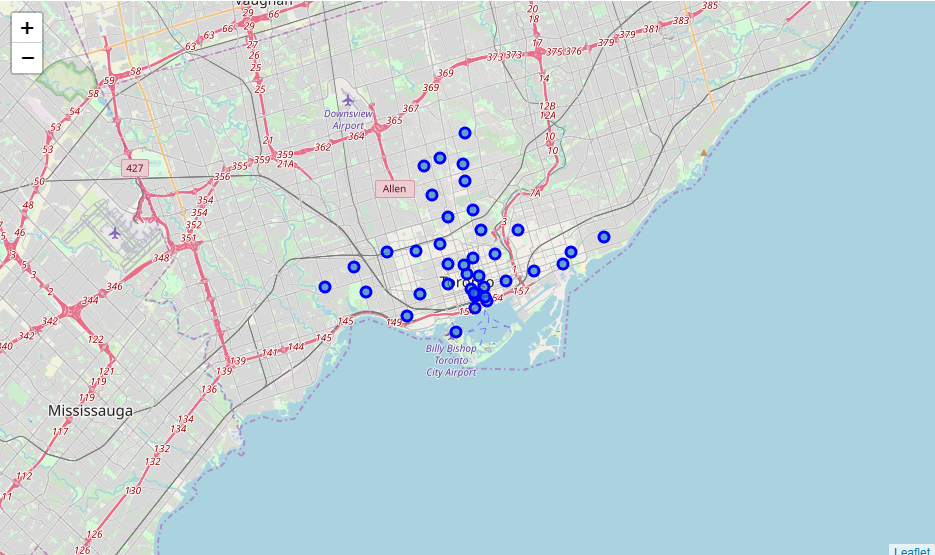

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [13]:
# define Foursquare Credentials and version
CLIENT_ID = 'DC1UAGXZVU1OQZKHUOKJFCYCV4ULXED2KGBMFFR1OSORPWUW' # your Foursquare ID
CLIENT_SECRET = 'L5UEEWX3O5U1LVYFQGOM5MJ3SNX40WSNRBHGZ5UBU4GBPUEB' # your Foursquare Secret
VERSION = '20200127'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DC1UAGXZVU1OQZKHUOKJFCYCV4ULXED2KGBMFFR1OSORPWUW
CLIENT_SECRET:L5UEEWX3O5U1LVYFQGOM5MJ3SNX40WSNRBHGZ5UBU4GBPUEB


In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude']
                                  )

Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Queen's Park
The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Business Reply Mail Processing Centre 969 Eastern
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, 

In [16]:
# check the size of the resulting dataframe

print(toronto_venues.shape)
toronto_venues.head()

(1703, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
3,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park
4,Davisville North,43.712751,-79.390197,Summerhill Market North,43.715499,-79.392881,Food & Drink Shop


In [17]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,56,56,56,56,56,56
"Brockton, Exhibition Place, Parkdale Village",22,22,22,22,22,22
Business Reply Mail Processing Centre 969 Eastern,14,14,14,14,14,14
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",15,15,15,15,15,15
"Cabbagetown, St. James Town",47,47,47,47,47,47
Central Bay Street,83,83,83,83,83,83
"Chinatown, Grange Park, Kensington Market",84,84,84,84,84,84
Christie,18,18,18,18,18,18


Check how many venues were returned for each neighborhood.

In [18]:
# remove data with sample number under threshold

threshold = 40
tgroup = toronto.groupby('Neighborhood')
tvgroup = toronto_venues.groupby('Neighborhood')

number = tvgroup.count()['Venue'].values > threshold

selected = tvgroup.count()['Venue'].index[number]

trow_index = []
tvrow_index = []

for neighborname in selected:
    trow_index = np.append(trow_index, tgroup.indices[neighborname])
    tvrow_index = np.append(tvrow_index, tvgroup.indices[neighborname])
    
trow_index.astype(int)
tvrow_index.astype(int)

toronto = toronto.iloc[trow_index,:].reset_index(drop=True)
toronto_venues = toronto_venues.iloc[tvrow_index,:].reset_index(drop=True)

In [19]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,56,56,56,56,56,56
"Cabbagetown, St. James Town",47,47,47,47,47,47
Central Bay Street,83,83,83,83,83,83
"Chinatown, Grange Park, Kensington Market",84,84,84,84,84,84
Church and Wellesley,84,84,84,84,84,84
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
"Design Exchange, Toronto Dominion Centre",100,100,100,100,100,100
"First Canadian Place, Underground city",100,100,100,100,100,100


In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.000000,0.020000,0.000000,0.00,0.010000,0.000000,0.030000,0.000000,...,0.000000,0.00,0.00000,0.00,0.020000,0.00,0.000000,0.010000,0.000000,0.01
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.00,0.017857,0.000000,0.000000,0.017857,...,0.000000,0.00,0.00000,0.00,0.017857,0.00,0.000000,0.000000,0.000000,0.00
2,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.00000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00
3,Central Bay Street,0.012048,0.000000,0.012048,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.00000,0.00,0.012048,0.00,0.000000,0.012048,0.000000,0.00
4,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.011905,0.000000,0.000000,...,0.000000,0.00,0.00000,0.00,0.047619,0.00,0.059524,0.011905,0.000000,0.00
5,Church and Wellesley,0.011905,0.011905,0.011905,0.000000,0.00,0.000000,0.011905,0.000000,0.000000,...,0.011905,0.00,0.00000,0.00,0.000000,0.00,0.011905,0.000000,0.011905,0.00
6,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.020000,0.000000,0.00,0.010000,0.000000,0.010000,0.000000,...,0.000000,0.00,0.00000,0.00,0.020000,0.00,0.000000,0.010000,0.000000,0.00
7,"Design Exchange, Toronto Dominion Centre",0.000000,0.000000,0.020000,0.000000,0.00,0.010000,0.000000,0.010000,0.000000,...,0.000000,0.00,0.00000,0.01,0.010000,0.00,0.000000,0.010000,0.000000,0.00
8,"First Canadian Place, Underground city",0.000000,0.000000,0.020000,0.000000,0.00,0.010000,0.000000,0.030000,0.000000,...,0.000000,0.00,0.00000,0.01,0.010000,0.00,0.000000,0.010000,0.000000,0.00
9,Harbourfront,0.021277,0.000000,0.000000,0.021277,0.00,0.021277,0.000000,0.021277,0.000000,...,0.000000,0.00,0.00000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00


In [22]:
toronto_grouped.shape

(18, 196)

In [23]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.07
1             Café  0.04
2       Steakhouse  0.04
3              Bar  0.04
4  Thai Restaurant  0.03


----Berczy Park----
            venue  freq
0     Coffee Shop  0.09
1    Cocktail Bar  0.05
2  Farmers Market  0.04
3          Bakery  0.04
4            Café  0.04


----Cabbagetown, St. James Town----
         venue  freq
0  Coffee Shop  0.06
1       Bakery  0.04
2         Café  0.04
3     Pharmacy  0.04
4  Pizza Place  0.04


----Central Bay Street----
                 venue  freq
0          Coffee Shop  0.16
1   Italian Restaurant  0.05
2       Ice Cream Shop  0.05
3                 Café  0.05
4  Japanese Restaurant  0.04


----Chinatown, Grange Park, Kensington Market----
                           venue  freq
0                           Café  0.07
1             Chinese Restaurant  0.06
2          Vietnamese Restaurant  0.06
3                    Coffee Shop  0.05
4  Vegetarian / Vegan Restaurant  0.0

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Asian Restaurant,Bakery,Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Café,Farmers Market,Seafood Restaurant,Steakhouse,Beer Bar,Greek Restaurant
2,"Cabbagetown, St. James Town",Coffee Shop,Italian Restaurant,Park,Café,Restaurant,Chinese Restaurant,Pub,Bakery,Pharmacy,Pizza Place
3,Central Bay Street,Coffee Shop,Italian Restaurant,Ice Cream Shop,Café,Sandwich Place,Japanese Restaurant,Juice Bar,Burger Joint,Department Store,Spa
4,"Chinatown, Grange Park, Kensington Market",Café,Vietnamese Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Coffee Shop,Mexican Restaurant,Bar,Grocery Store,Dessert Shop


In [26]:
# set number of clusters
from sklearn.cluster import KMeans

kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 0, 2, 2, 2, 2, 2, 0], dtype=int32)

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,2,Coffee Shop,Café,Bar,Steakhouse,Asian Restaurant,Bakery,Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant
1,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Café,Farmers Market,Seafood Restaurant,Steakhouse,Beer Bar,Greek Restaurant
2,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675,2,Coffee Shop,Italian Restaurant,Park,Café,Restaurant,Chinese Restaurant,Pub,Bakery,Pharmacy,Pizza Place
3,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,Coffee Shop,Italian Restaurant,Ice Cream Shop,Café,Sandwich Place,Japanese Restaurant,Juice Bar,Burger Joint,Department Store,Spa
4,M5T,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,2,Café,Vietnamese Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Coffee Shop,Mexican Restaurant,Bar,Grocery Store,Dessert Shop


In [32]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

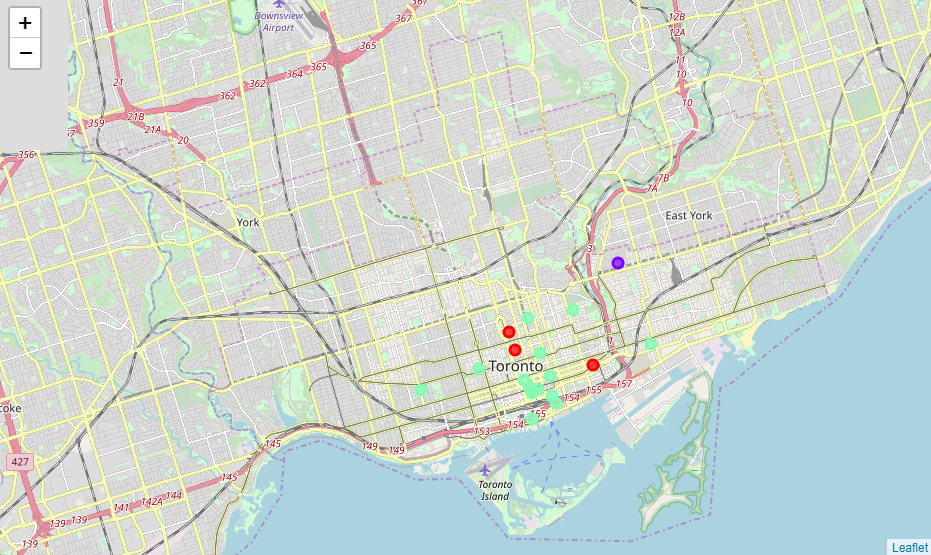

In [29]:
# cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0,2] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,M5G,Central Bay Street,0,Coffee Shop,Italian Restaurant,Ice Cream Shop,Café,Sandwich Place,Japanese Restaurant,Juice Bar,Burger Joint,Department Store,Spa
9,M5A,Harbourfront,0,Coffee Shop,Pub,Park,Bakery,Mexican Restaurant,Breakfast Spot,Café,Gym / Fitness Center,Farmers Market,Performing Arts Venue
12,M7A,Queen's Park,0,Coffee Shop,Park,Gym,College Cafeteria,Sandwich Place,Burrito Place,Salad Place,Café,Chinese Restaurant,Portuguese Restaurant


In [30]:
# cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0,2] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,M4K,"The Danforth West, Riverdale",1,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Spa,Bookstore,Bubble Tea Shop,Juice Bar,Caribbean Restaurant


In [31]:
# cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0,2] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5H,"Adelaide, King, Richmond",2,Coffee Shop,Café,Bar,Steakhouse,Asian Restaurant,Bakery,Restaurant,Thai Restaurant,Sushi Restaurant,Seafood Restaurant
1,M5E,Berczy Park,2,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Café,Farmers Market,Seafood Restaurant,Steakhouse,Beer Bar,Greek Restaurant
2,M4X,"Cabbagetown, St. James Town",2,Coffee Shop,Italian Restaurant,Park,Café,Restaurant,Chinese Restaurant,Pub,Bakery,Pharmacy,Pizza Place
4,M5T,"Chinatown, Grange Park, Kensington Market",2,Café,Vietnamese Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Coffee Shop,Mexican Restaurant,Bar,Grocery Store,Dessert Shop
5,M4Y,Church and Wellesley,2,Coffee Shop,Japanese Restaurant,Restaurant,Sushi Restaurant,Gay Bar,Hotel,Gym,Gastropub,Café,Fast Food Restaurant
6,M5L,"Commerce Court, Victoria Hotel",2,Coffee Shop,Café,Hotel,Restaurant,Gym,Steakhouse,Gastropub,Seafood Restaurant,Bakery,Deli / Bodega
7,M5K,"Design Exchange, Toronto Dominion Centre",2,Coffee Shop,Café,Hotel,Restaurant,Steakhouse,Bar,Italian Restaurant,Gastropub,Seafood Restaurant,Lounge
8,M5X,"First Canadian Place, Underground city",2,Coffee Shop,Café,Restaurant,Steakhouse,Hotel,Seafood Restaurant,Bar,Japanese Restaurant,Asian Restaurant,Deli / Bodega
10,M5J,"Harbourfront East, Toronto Islands, Union Station",2,Coffee Shop,Aquarium,Hotel,Café,Italian Restaurant,Scenic Lookout,Restaurant,Fried Chicken Joint,Brewery,Music Venue
11,M6J,"Little Portugal, Trinity",2,Bar,Men's Store,Coffee Shop,Restaurant,Asian Restaurant,Vietnamese Restaurant,Café,Pizza Place,Japanese Restaurant,Brewery
